# llc temporal smoothing development

In [1]:
import os, shutil

import numpy as np
import pandas as pd
import xarray as xr
from datetime import timedelta, datetime
import geopandas

import dask
from dask.delayed import delayed

%matplotlib inline
from matplotlib import pyplot as plt

import mitequinox.utils as ut
import mitequinox.parcels as pa

In [2]:
from dask.distributed import Client, LocalCluster
from dask_jobqueue import PBSCluster

# ** processes and cores may be adjusted in order to have more memory or inversely more 
# ** computational ressource

processing = 1

if processing==0:
    cluster = LocalCluster()
elif processing==1:
    # parcels simulation
    cluster = PBSCluster(processes=4, cores=4, walltime='48:00:00')
    w = cluster.scale(jobs=10)
elif processing==2:
    # post processing
    cluster = PBSCluster()
    w = cluster.scale(jobs=2)
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.34:8787/status,
Dashboard: http://10.148.0.34:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.34:55626,Workers: 0
Dashboard: http://10.148.0.34:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


---

## load llc data

In [3]:
# load llc data
ds = ut.load_data(V=['SSU', 'SSV', 'Eta', 'SST', 'SSS'])
grd = ut.load_grd(V=["XC", "YC", "XG", "YG", "Depth"])
ds = xr.merge([ds, grd])
#ds

---

## select time window and smooth temporally

*Several tiles in the south and north tiles could be deleted eventually as they are on land or not relevant with criterium on Depth or SST*

See `rearrange.ipynb` and `tile.ipynb` for more details

In [4]:
#cluster.close()

In [32]:
#time_slice = slice("2012/02/01", "2012/02/02")
time_slice = slice(pd.Timestamp("2012/02/01"), pd.Timestamp("2012/02/02"))
dt = "6H"

def temporal_zoom_roll(ds, time_slice, dt):
    """ select temporal subset and apply a rolling average of size dt (e.g. "6H", ...) """
    _dt = pd.Timedelta(dt)*2
    time_slice_extended = slice(time_slice.start-_dt, time_slice.stop+_dt)
    di = int(_dt/pd.Timedelta("1H"))
    return (ds.sel(time=time_slice_extended)
            .rolling(time=di, center=True)
            .mean()
            .sel(time=time_slice)
           )


ds_raw = ds.sel(time=time_slice).persist()
ds_smooth = temporal_zoom_roll(ds, time_slice, dt).persist()

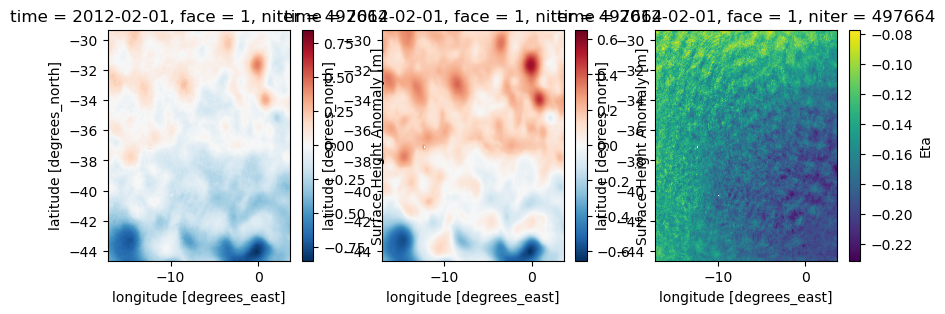

In [45]:
kw = dict(
    face = 1,
    i = slice(1000, 2000),
    j = slice(1000, 2000),
)


fig, axes = plt.subplots(1,3, figsize=(10,3))

ax = axes[0]
da_raw = ds_raw.sel(**kw).isel(time=0).Eta
da_raw.plot(x="XC", y="YC", ax=ax)

ax = axes[1]
da_smooth = ds_smooth.sel(**kw).isel(time=0).Eta
da_smooth.plot(x="XC", y="YC", ax=ax)

ax = axes[2]
da = da_raw - da_smooth
da.plot(x="XC", y="YC", ax=ax)


## Close cluster

In [46]:
cluster.close()